In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('Set2')

In [3]:
import glob
import os

def get_latest_file_glob(pat):    
    list_of_files = glob.glob(pat) # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    return latest_file

In [4]:
latest_niv = get_latest_file_glob('datagov_archive/corona_tested_individuals_ver_*.csv.gz')
niv = pd.read_csv(latest_niv, 
                  encoding='utf-8-sig', low_memory=False, na_values=['None'],
                  parse_dates=[0])
#niv['test_date'] = niv.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
niv.head()

test_date  cough  fever  sore_throat  shortness_of_breath  head_ache  \
0 2020-10-29      0      0            0                    0          0   
1 2020-10-29      0      0            0                    0          0   
2 2020-10-29      0      0            0                    0          0   
3 2020-10-29      0      0            0                    0          0   
4 2020-10-29      0      0            0                    0          0   

  corona_result age_60_and_above gender test_indication  
0         שלילי               No    זכר           Other  
1         שלילי               No    זכר           Other  
2         שלילי               No    זכר           Other  
3         שלילי               No    זכר           Other  
4         שלילי               No    זכר           Other

In [5]:
symptom_cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
niv['symp_num'] = niv[symptom_cols].fillna(0).sum(axis=1).astype(int)
niv['no_symp'] = (~niv[symptom_cols].fillna(0).any(axis=1))
symptom_cols.append('no_symp')


In [6]:
latest_bdi = get_latest_file_glob('datagov_archive/corona_lab_tests_ver_*.csv.gz')
bdi = pd.read_csv(latest_bdi, encoding='utf-8', parse_dates=[0,1])

In [7]:
bdi['orig_test_date'] = bdi.test_date
bdi['test_date'] = bdi.test_date.combine_first(bdi.result_date)

In [8]:
bdi.head()

test_date result_date corona_result  lab_id  test_for_corona_diagnosis  \
0 2020-08-09  2020-08-09         חיובי       2                          1   
1 2020-08-09  2020-08-09         שלילי       2                          1   
2 2020-08-10  2020-08-10         שלילי       2                          1   
3 2020-03-11  2020-03-11         שלילי      32                          1   
4 2020-03-11  2020-03-11         חיובי      32                          0   

  is_first_Test orig_test_date  
0            No            NaT  
1           Yes            NaT  
2           Yes            NaT  
3           Yes     2020-03-11  
4            No     2020-03-11

In [9]:
bdi.shape

(4812532, 7)

In [10]:
niv.corona_result.value_counts()

שלילי    2319294
חיובי     215981
אחר        39741
Name: corona_result, dtype: int64

In [11]:
bdi.corona_result.value_counts()

שלילי                 4327488
חיובי                  381153
חיובי גבולי             53778
לא בוצע/פסול 999        47339
לא ודאי                  1417
בעבודה                    807
לא ודאי ישן               397
חיובי באיגום               97
חיובי גבולי באיגום         56
Name: corona_result, dtype: int64

In [12]:
niv.corona_result.value_counts()

שלילי    2319294
חיובי     215981
אחר        39741
Name: corona_result, dtype: int64

In [13]:
niv.test_indication.value_counts()

Other                     2388012
Contact with confirmed     162470
Abroad                      24534
Name: test_indication, dtype: int64

In [14]:
niv.age_60_and_above.value_counts()

No     1789042
Yes     261659
Name: age_60_and_above, dtype: int64

In [15]:
niv.loc[(niv.test_indication=='Other') & (niv.no_symp), 'test_indication'] = 'Other-Unknown'
niv.loc[(niv.test_indication=='Other-Unknown') & (niv.age_60_and_above=='Yes'), 'test_indication'] = 'Other-60_above'
niv.loc[(niv.test_indication=='Other') & (~niv.no_symp), 'test_indication'] = 'Other-Symptoms'

In [16]:
result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'אחר': 'other',
    'לא בוצע': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
}
niv['corona_result'] = niv.corona_result.map(result_map)


In [17]:
bdi_result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'חיובי גבולי': 'borderline',
    'לא בוצע/פסול 999': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
}
bdi['corona_result'] = bdi.corona_result.map(bdi_result_map)

In [18]:
bdi.corona_result.value_counts()

negative       4327488
positive        381153
borderline       53778
not_done         47339
uncertain         1417
in_progress        807
Name: corona_result, dtype: int64

In [19]:
rec = pd.read_csv(get_latest_file_glob('datagov_archive/corona_recovered_ver_*.csv.gz'), encoding='utf-8-sig')
rec = rec.iloc[:, 0:5]
rec.head()

days_between_pos_and_neg total_tests_count age_group gender  \
0                        19                 9     40-49    זכר   
1                        22                 9     30-39    זכר   
2                        26                 9     30-39    זכר   
3                        28                 9     30-39   נקבה   
4                        23                 9     20-29   נקבה   

          test_indication  
0                  Abroad  
1  Contact with confirmed  
2  Contact with confirmed  
3                  Abroad  
4  Contact with confirmed

In [20]:
x = (rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('+', '')
                                .astype(int)))
 .groupby('total_tests_count').days_between_pos_and_neg.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()
x['test_sum'] = x.total_tests_count*x['size']
x

total_tests_count   size  min  max       mean  median  test_sum
0                  2      6    6   17  12.833333      13        12
1                  3  11061    2  112  16.665582      17     33183
2                  4   5081    2  114  21.462114      21     20324
3                  5   3127    2  106  24.647905      25     15635
4                  6   1786    6   96  27.668533      27     10716
5                  7   1063    8  108  30.398871      30      7441
6                  8    597    3  103  33.475712      33      4776
7                  9    357    3   78  35.700280      35      3213
8                 10    573    5  106  41.130890      41      5730

In [21]:
(rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('10+', '11').replace('11+', '12')
                                .astype(int)))
 .total_tests_count.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()

index  total_tests_count
0    size       23651.000000
1     min           2.000000
2     max          12.000000
3    mean           4.320156
4  median           4.000000

In [22]:
rec.iloc[rec.days_between_pos_and_neg.nlargest(10).index]


days_between_pos_and_neg total_tests_count age_group gender  \
9432                        114                 4       60+    זכר   
12342                       112                 3     30-39    זכר   
9304                        111                 4     20-29    זכר   
1600                        108                 7     40-49   נקבה   
6311                        106                 5     30-39    זכר   
23175                       106               10+      0-19   נקבה   
9696                        105                 4     30-39   נקבה   
456                         103                 8     50-59   נקבה   
20936                       103                 3      0-19    זכר   
23273                       100               10+       60+    זכר   

              test_indication  
9432                    Other  
12342  Contact with confirmed  
9304                    Other  
1600   Contact with confirmed  
6311   Contact with confirmed  
23175  Contact with confirmed  
9696                    Other  
456    Contact with confirmed  
20936                  Abroad  
23273  Contact with confirmed

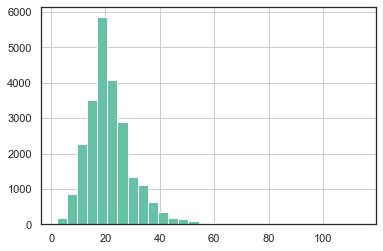

In [23]:
rec.days_between_pos_and_neg.hist(bins=30)

In [24]:
iso = pd.read_csv(get_latest_file_glob('datagov_archive/corona_isolation_per_day_ver_*.csv.gz'),
                  encoding='utf-8-sig', low_memory=False)
iso.head()

date  isolated_today_contact_with_confirmed  isolated_today_abroad  \
0  2020-10-28                                  33802                  31379   
1  2020-10-27                                  34765                  31110   
2  2020-10-26                                  36129                  30675   
3  2020-10-25                                  36518                  30006   
4  2020-10-24                                  37674                  29478   

  new_contact_with_confirmed new_from_abroad  
0                       3137            2307  
1                       3519            2175  
2                       3739            2549  
3                       2067            1650  
4                       1328            1493

In [25]:
niv.dtypes

test_date              datetime64[ns]
cough                           int64
fever                           int64
sore_throat                     int64
shortness_of_breath             int64
head_ache                       int64
corona_result                  object
age_60_and_above               object
gender                         object
test_indication                object
symp_num                        int32
no_symp                          bool
dtype: object

In [26]:
niv.age_60_and_above.value_counts()

No     1789042
Yes     261659
Name: age_60_and_above, dtype: int64

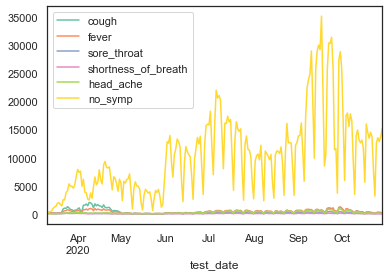

In [27]:
niv.groupby('test_date')[symptom_cols].sum().plot()

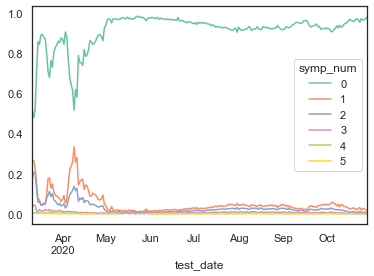

In [28]:
sn = niv.groupby(['test_date', 'symp_num']).size().unstack()
(sn.div(sn.sum(axis=1), axis=0)).plot()

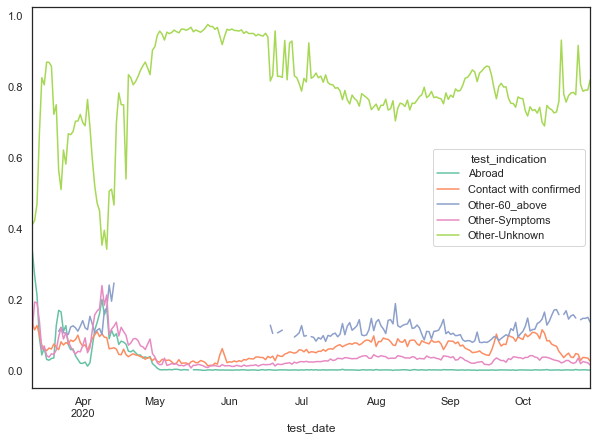

In [29]:
ti = niv.groupby(['test_date', 'test_indication']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

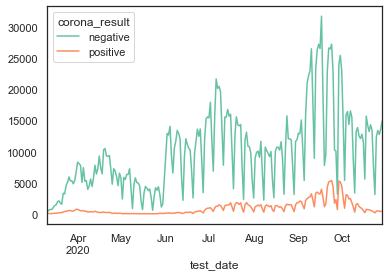

In [30]:
niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [31]:
bdi.dtypes

test_date                    datetime64[ns]
result_date                  datetime64[ns]
corona_result                        object
lab_id                                int64
test_for_corona_diagnosis             int64
is_first_Test                        object
orig_test_date               datetime64[ns]
dtype: object

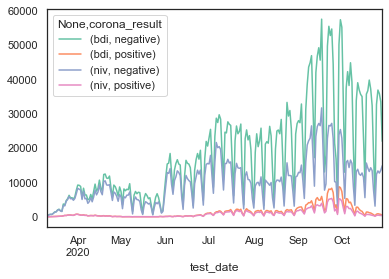

In [32]:
pd.concat([bdi[(bdi.test_date>'2020') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.test_for_corona_diagnosis)].groupby(['test_date', 'corona_result']).size().unstack(),
           niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack()], keys=['bdi', 'niv'], axis=1).plot()

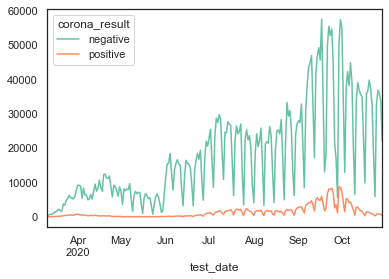

In [33]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.test_for_corona_diagnosis)].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [34]:
pone = bdi[(bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)][['test_date', 'corona_result']].fillna('Other').groupby(['test_date', 'corona_result'], sort=False).size().unstack()
pone[pone.positive>20]

corona_result  positive  negative  in_progress  Other  not_done  borderline  \
test_date                                                                     
2020-08-09       1613.0   21219.0          1.0    NaN      77.0        94.0   
2020-08-10       1859.0   21918.0          1.0    NaN     112.0       162.0   
2020-03-12         31.0     615.0          2.0    NaN       1.0         NaN   
2020-03-25        502.0    5304.0         21.0   49.0      42.0         NaN   
2020-03-13         33.0     721.0          NaN    NaN       NaN         NaN   
...                 ...       ...          ...    ...       ...         ...   
2020-10-25        782.0   32767.0          8.0  104.0     148.0       140.0   
2020-10-26        898.0   36979.0          4.0   38.0     151.0       188.0   
2020-10-27        803.0   35941.0          5.0    NaN     130.0       155.0   
2020-10-29        360.0   22034.0          4.0    NaN     131.0        69.0   
2020-10-28        706.0   33535.0          5.0    NaN     137.0       135.0   

corona_result  uncertain  
test_date                 
2020-08-09           NaN  
2020-08-10           NaN  
2020-03-12           NaN  
2020-03-25           NaN  
2020-03-13           NaN  
...                  ...  
2020-10-25         104.0  
2020-10-26          44.0  
2020-10-27          26.0  
2020-10-29          42.0  
2020-10-28          24.0  

[222 rows x 7 columns]

In [35]:
pone.tail(5)

corona_result  positive  negative  in_progress  Other  not_done  borderline  \
test_date                                                                     
2020-10-25        782.0   32767.0          8.0  104.0     148.0       140.0   
2020-10-26        898.0   36979.0          4.0   38.0     151.0       188.0   
2020-10-27        803.0   35941.0          5.0    NaN     130.0       155.0   
2020-10-29        360.0   22034.0          4.0    NaN     131.0        69.0   
2020-10-28        706.0   33535.0          5.0    NaN     137.0       135.0   

corona_result  uncertain  
test_date                 
2020-10-25         104.0  
2020-10-26          44.0  
2020-10-27          26.0  
2020-10-29          42.0  
2020-10-28          24.0

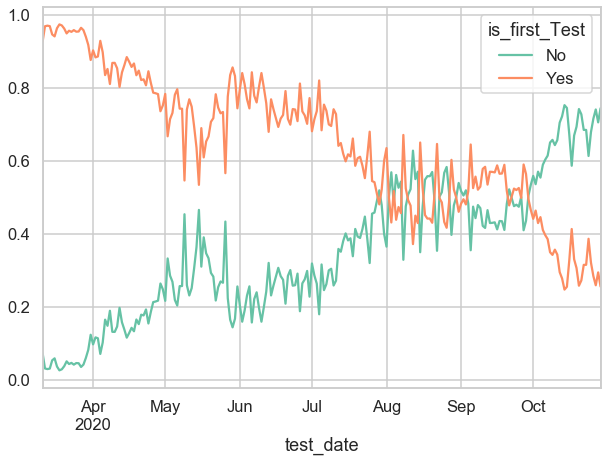

In [123]:
ti = bdi[(bdi.test_date>'2020') 
         & (bdi.test_date<'2021') 
         & (bdi.test_for_corona_diagnosis)].groupby(['test_date', 'is_first_Test']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

In [37]:
(ti.div(ti.sum(axis=1), axis=0))

is_first_Test        No       Yes
test_date                        
2020-03-11     0.154639  0.845361
2020-03-12     0.051205  0.948795
2020-03-13     0.035573  0.964427
2020-03-14     0.034301  0.965699
2020-03-15     0.102439  0.897561
...                 ...       ...
2020-10-25     0.693898  0.306102
2020-10-26     0.727006  0.272994
2020-10-27     0.750734  0.249266
2020-10-28     0.715843  0.284157
2020-10-29     0.752947  0.247053

[233 rows x 2 columns]

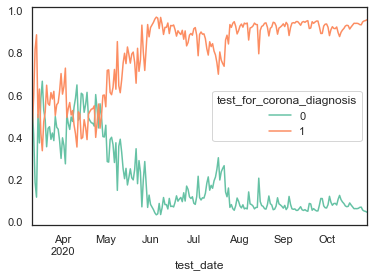

In [38]:
ti = bdi[(bdi.is_first_Test=='No')].groupby(['test_date', 'test_for_corona_diagnosis']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot()

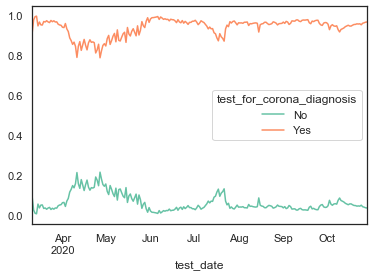

In [39]:
ti = bdi.groupby(['test_date', 'test_for_corona_diagnosis']).size().unstack()
ti = ti.rename(columns={0: 'No', 1: 'Yes'})
(ti.div(ti.sum(axis=1), axis=0)).plot()

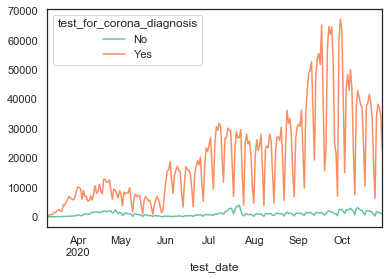

In [40]:
ti.plot()

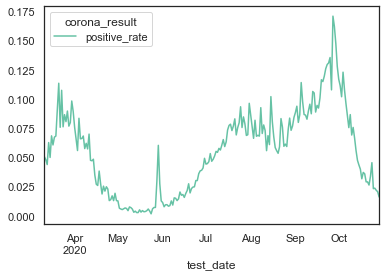

In [41]:
(bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)]
 .groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative+x.borderline+x.uncertain))[['positive_rate']]
 .plot())

In [42]:
import altair as alt

In [43]:
ti.tail()

test_for_corona_diagnosis    No    Yes
test_date                             
2020-10-25                 1690  34053
2020-10-26                 1578  38302
2020-10-27                 1437  37060
2020-10-28                 1227  34542
2020-10-29                  776  22640

In [44]:
ti.Yes.sum() + ti.No.sum()

4812524

In [45]:
alt.Chart(ti.reset_index().assign(total=lambda x: (x.Yes+x.No))).mark_line().encode(
    x='test_date',
    y='total',
    tooltip=['test_date', 'total']
).interactive()

alt.Chart(...)

In [46]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)]
 .groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative+x.borderline+x.uncertain)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [47]:
alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive']
).interactive()

alt.Chart(...)

In [48]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')
          ]
 .groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative+x.borderline+x.uncertain)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [49]:
hos_cols = {'תאריך': 'date',
            'חולים קשה': 'critical',
            'חולים בינוני': 'medium',
            'מונשמים': 'resp'}

In [50]:
get_latest_file_glob('datagov_archive/corona_hospitalization_ver_*.xlsx.gz')

'datagov_archive\\corona_hospitalization_ver_00126_20201101115450.xlsx.gz'

In [51]:
import gzip
hos = (pd.read_excel(gzip.open(get_latest_file_glob('datagov_archive/corona_hospitalization_ver_*.xlsx.gz')))
       .fillna('<15')
      .rename(columns=hos_cols)
      .assign(date = lambda x: x.date.apply(pd.to_datetime))
      .assign(critical = lambda x: x.critical.replace('<15', '15').astype(int))
      .assign(medium = lambda x: x.medium.fillna('<15').replace('<15', '15').astype(int))
      .assign(resp = lambda x: x.resp.replace('<15', '15').astype(int)))
#hos['test_date'] = hos.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
hos.tail()

date  מאושפזים  אחוז נשים מאושפזות  גיל ממוצע מאושפזים  \
228 2020-10-25       974                41.5                  66   
229 2020-10-26       905                42.8                  66   
230 2020-10-27       841                43.2                  66   
231 2020-10-28       828                43.7                  65   
232 2020-10-29       783                43.2                  65   

     סטיית תקן גיל מאושפזים  resp  אחוז נשים מונשמות  גיל ממוצע מונשמים  \
228                    18.3   185               31.9                 68   
229                    18.5   197               31.5                 67   
230                    18.5   190               34.2                 67   
231                    18.2   186               34.4                 67   
232                    17.7   185               34.6                 67   

     סטיית תקן גיל מונשמים  חולים קל  ...  סטיית תקן גיל חולים קל  medium  \
228                   12.0       317  ...                    22.9     158   
229                   12.2       281  ...                    23.1     140   
230                   12.4       236  ...                    24.1     141   
231                   12.2       234  ...                    23.5     137   
232                   11.6       218  ...                    22.4     125   

     אחוז נשים חולות בינוני  גיל ממוצע חולים בינוני  \
228                    44.3                      68   
229                    45.7                      68   
230                    48.9                      66   
231                    48.2                      66   
232                    47.2                      67   

    סטיית תקן גיל חולים בינוני critical אחוז נשים חולות קשה  \
228                       17.2      499                35.9   
229                       18.4      484                37.6   
230                       18.8      464                36.9   
231                       17.5      457                37.0   
232                       17.1      440                37.5   

     גיל ממוצע חולים קשה  סטיית תקן גיל חולים קשה  חולים קשה מצטבר  
228                   69                     13.9             6778  
229                   69                     14.3             6814  
230                   68                     14.1             6848  
231                   68                     14.2             6877  
232                   67                     14.3             6895  

[5 rows x 22 columns]

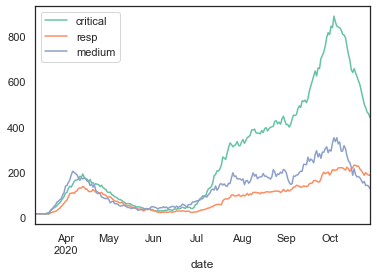

In [52]:
(hos[['date', 'critical', 'resp', 'medium']].set_index('date').plot())

In [53]:
hos_and_rate = hos[['date', 'critical', 'resp', 'medium']].rename(columns={'date': 'test_date'}).merge(pr, on='test_date')
hos_and_rate.head()


test_date  critical  resp  medium  borderline  in_progress  negative  \
0 2020-03-11        15    15      15         0.0         18.0     324.0   
1 2020-03-12        15    15      15         0.0          2.0     616.0   
2 2020-03-13        15    15      15         0.0          0.0     721.0   
3 2020-03-14        15    15      15         0.0          3.0     704.0   
4 2020-03-15        15    15      15         0.0         93.0    1025.0   

   not_done  positive  uncertain  positive_rate  
0       0.0      45.0        0.0       0.121951  
1       1.0      45.0        0.0       0.068079  
2       0.0      38.0        0.0       0.050066  
3       1.0      50.0        0.0       0.066313  
4       9.0     103.0        0.0       0.091312

In [54]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [55]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.12]
               .assign(positive = lambda x: x.positive.ewm(span=7).mean())
               .assign(positive_label ='positive')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positives (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

No handles with labels found to put in legend.


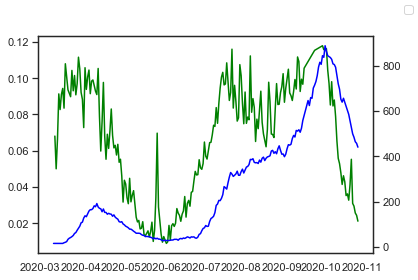

In [56]:
sns.lineplot(data=hos_and_rate[hos_and_rate.positive_rate<0.12].set_index('test_date').positive_rate, color="g")
ax2 = plt.twinx()
sns.lineplot(data=hos_and_rate.set_index('test_date').critical, color="b", ax=ax2)
ax2.figure.legend()


In [57]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical+med')
               .assign(crit_med = lambda x: (x.critical+x.medium).ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_med',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [58]:
hos_and_rate['pos_pct_change'] = hos_and_rate.positive_rate.pct_change()
hos_and_rate['crit_pct_change'] = hos_and_rate.critical.pct_change()


In [59]:
c1 = alt.Chart(hos_and_rate
               .assign(pos_pct_change = lambda x: x.pos_pct_change.ewm(span=7).mean())
              ).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='pos_pct_change',
    tooltip=['test_date', 'positive_rate'],
)
c2 = alt.Chart(hos_and_rate
               .assign(crit_pct_change = lambda x: x.crit_pct_change.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_pct_change',
    tooltip=['test_date', 'critical'],
)


alt.layer(c1, c2).properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

## Positive rate by Lab

In [60]:
polab = bdi[(bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)][['test_date', 'lab_id', 'corona_result']].fillna('Other').groupby(['test_date', 'lab_id', 'corona_result']).size().unstack().fillna(0)
polab['total_tests'] = polab.sum(axis=1)
polab['positive_rate'] = polab.positive/(polab.positive+polab.negative+polab.borderline+polab.uncertain)

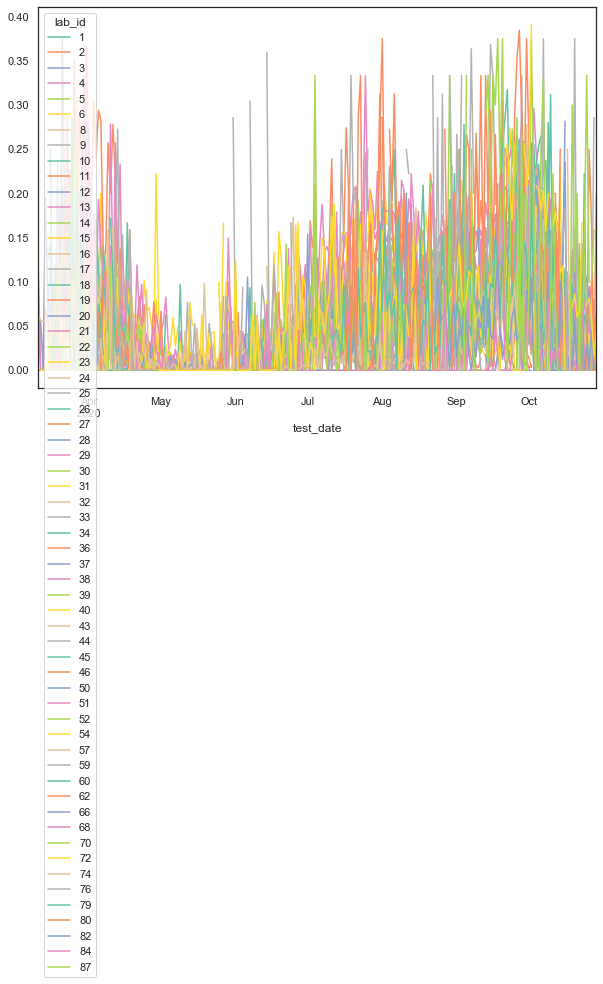

In [61]:
polab[polab.positive_rate<0.4].positive_rate.unstack().plot(figsize=(10,7))

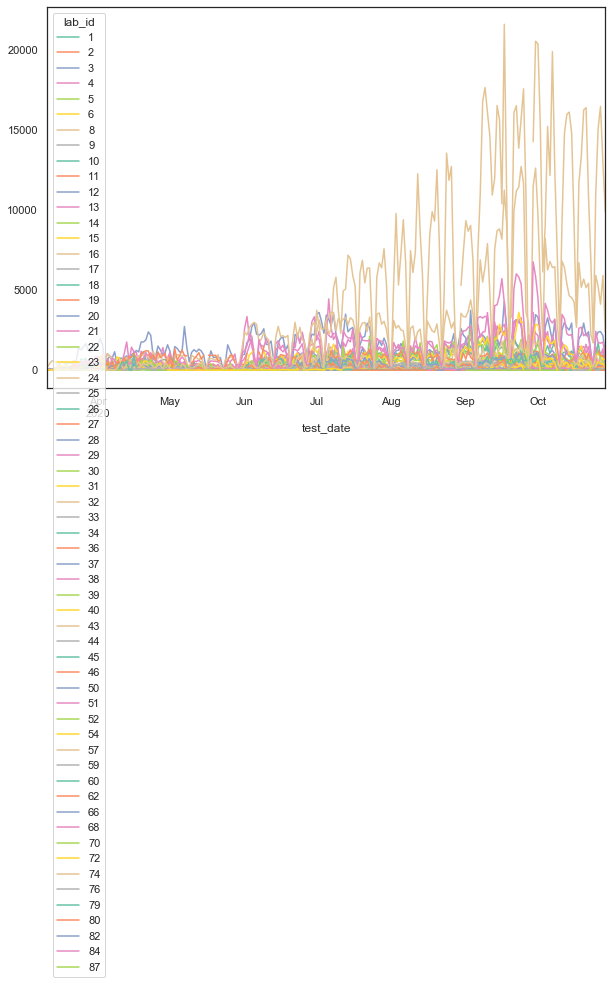

In [62]:
polab.total_tests.unstack().plot(figsize=(10,7))

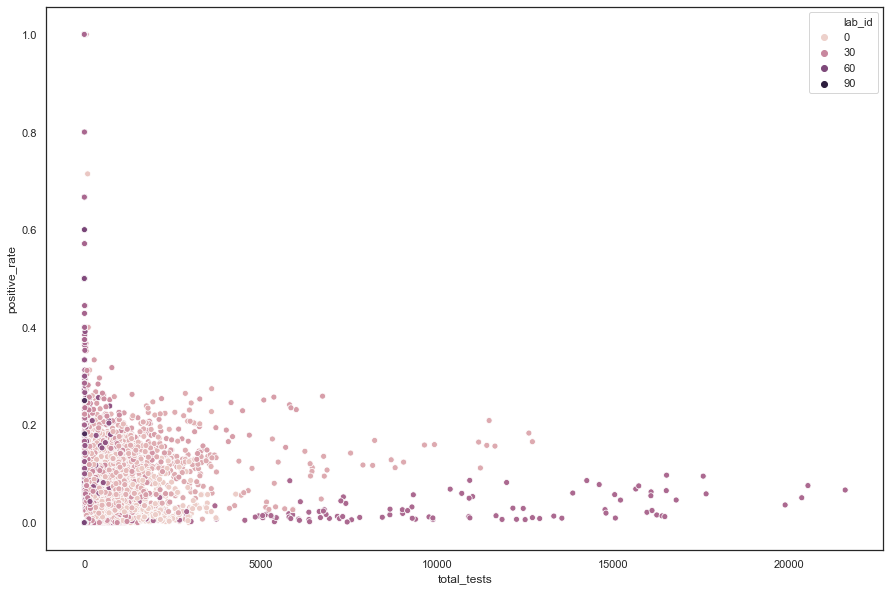

In [63]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(data=polab.reset_index(), x='total_tests', y='positive_rate', hue='lab_id')


In [64]:
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [65]:
alt.Chart(polab.reset_index()).mark_point().encode(
    x='total_tests',
    y='positive_rate',
    color='lab_id:N',
    tooltip=['lab_id', 'test_date', 'total_tests', 'positive_rate']
).properties(width=600, height=450)

alt.Chart(...)

In [66]:
(polab.reset_index().groupby('lab_id')[['positive', 'negative', 'total_tests']]
 .sum().sort_values(('total_tests'), ascending=False)
 .assign(positive_rate = lambda x: (x.positive / (x.negative+x.negative)).mul(100).round(1)))

corona_result  positive  negative  total_tests  positive_rate
lab_id                                                       
43              35705.0  995156.0    1044408.0            1.8
16              60430.0  545513.0     610050.0            5.5
3               10715.0  341473.0     354440.0            1.6
21              44494.0  262834.0     312169.0            8.5
13              25778.0  231564.0     264021.0            5.6
...                 ...       ...          ...            ...
79                  0.0       0.0         42.0            NaN
74                  9.0       0.0         29.0            inf
59                  7.0       0.0         27.0            inf
87                  0.0       0.0         25.0            NaN
72                  0.0       0.0         20.0            NaN

[61 rows x 4 columns]

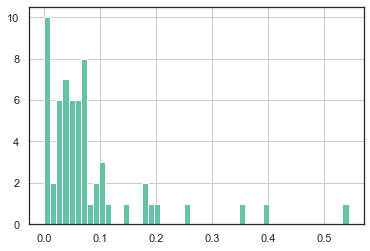

In [67]:
polab.reset_index().groupby('lab_id').positive_rate.mean().hist(bins=50)

In [68]:
top_5_labs = bdi[(bdi.test_for_corona_diagnosis==1)].lab_id.value_counts().index[:10]
top_5_labs

Int64Index([43, 16, 3, 21, 13, 4, 15, 10, 12, 14], dtype='int64')

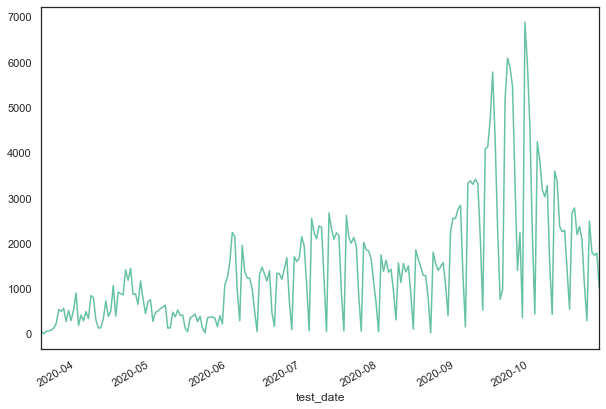

In [69]:
bdi[(bdi.lab_id==21)].groupby('test_date').size().plot(figsize=(10,7))

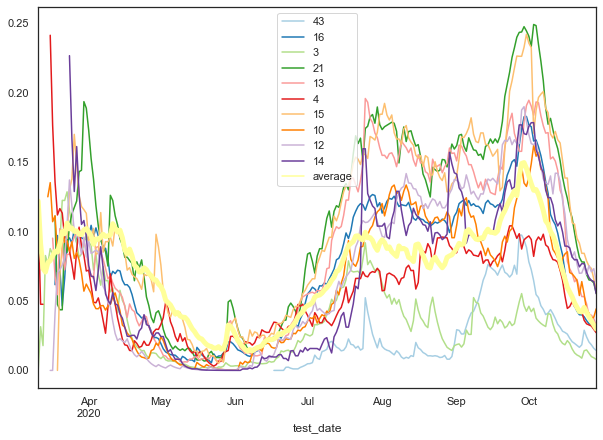

In [70]:
sns.set_palette(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928'])
forp = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1).ewm(span=7).mean()
ax = forp[forp<0.3].plot(figsize=(10,7))
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=([1.5]*10+[5])[i])


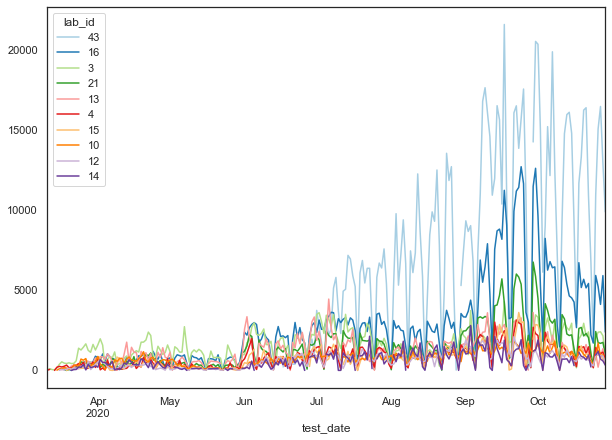

In [71]:
forp = polab.total_tests.unstack()[top_5_labs]
ax = forp.plot(figsize=(10,7))
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=([1.5]*10+[5])[i])


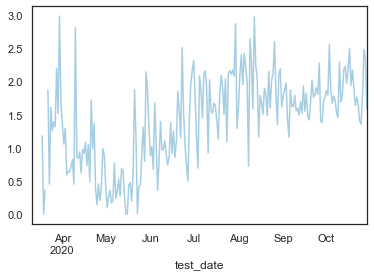

In [72]:
top_labs_pr = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1)
top_labs_pr['ratio_21'] = top_labs_pr.loc[:, 21]/top_labs_pr.average
top_labs_pr.ratio_21.plot()

In [73]:
bdi[bdi.lab_id==21].shape[0]/bdi.shape[0]

0.06776308188703992

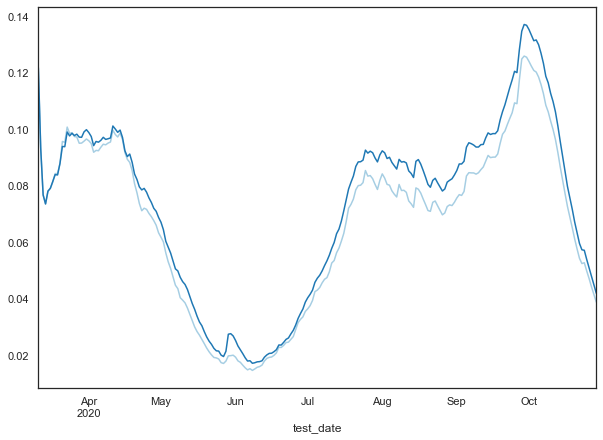

In [74]:
ax = (bdi[~(bdi.lab_id.isin([13,21]))].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo.ewm(7).mean().plot(figsize=(10,7))
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr.ewm(7).mean().plot(ax=ax, figsize=(10,7))

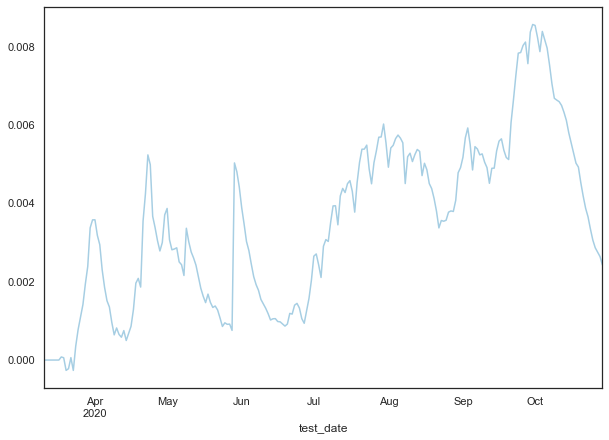

In [75]:
pd.concat([(bdi[bdi.lab_id!=21].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo,
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr], axis=1).assign(dif = lambda x: x.pr-x.pr_wo).dif.ewm(7).mean().plot(figsize=(10,7))

In [76]:
alt.Chart(polab[polab.total_tests>100].reset_index()).mark_point(size=2).encode(
    x='test_date',
    y='total_tests',
    color='positive_rate:Q',
    tooltip=['lab_id', 'test_date', 'total_tests', 'positive_rate']
).properties(width=600, height=450)

alt.Chart(...)

In [77]:
xx = (polab.reset_index().groupby('lab_id')[['positive', 'negative', 'total_tests']]
 .sum().sort_values(('total_tests'), ascending=False)
 .assign(positive_rate = lambda x: (x.positive / (x.negative+x.negative)).mul(100).round(1))
 .assign(positive_rq = lambda x: pd.qcut(x.positive_rate, 5))
)
xx

corona_result  positive  negative  total_tests  positive_rate   positive_rq
lab_id                                                                     
43              35705.0  995156.0    1044408.0            1.8  (0.499, 1.9]
16              60430.0  545513.0     610050.0            5.5   (4.66, 8.9]
3               10715.0  341473.0     354440.0            1.6  (0.499, 1.9]
21              44494.0  262834.0     312169.0            8.5   (4.66, 8.9]
13              25778.0  231564.0     264021.0            5.6   (4.66, 8.9]
...                 ...       ...          ...            ...           ...
79                  0.0       0.0         42.0            NaN           NaN
74                  9.0       0.0         29.0            inf    (8.9, inf]
59                  7.0       0.0         27.0            inf    (8.9, inf]
87                  0.0       0.0         25.0            NaN           NaN
72                  0.0       0.0         20.0            NaN           NaN

[61 rows x 5 columns]

In [78]:
polab = polab.reset_index()
polab['total_pr'] = polab.lab_id.map(xx.positive_rate)
polab['total_prq'] = polab.lab_id.map(xx.positive_rq)
polab = polab.set_index(['test_date', 'lab_id'])
polab.head()

corona_result      Other  borderline  in_progress  negative  not_done  \
test_date  lab_id                                                       
2020-03-11 1         0.0         0.0          0.0       0.0       0.0   
           2         0.0         0.0          0.0      70.0       0.0   
           3         1.0         0.0          1.0      36.0       0.0   
           4         0.0         0.0          0.0      16.0       0.0   
           6         0.0         0.0         16.0       0.0       0.0   

corona_result      positive  uncertain  total_tests  positive_rate  total_pr  \
test_date  lab_id                                                              
2020-03-11 1            2.0        0.0          2.0       1.000000      29.1   
           2            0.0        0.0         70.0       0.000000       1.8   
           3            0.0        0.0         38.0       0.000000       1.6   
           4            2.0        0.0         18.0       0.111111       3.6   
           6            0.0        0.0         16.0            NaN       1.4   

corona_result         total_prq  
test_date  lab_id                
2020-03-11 1         (8.9, inf]  
           2       (0.499, 1.9]  
           3       (0.499, 1.9]  
           4        (3.0, 4.66]  
           6       (0.499, 1.9]

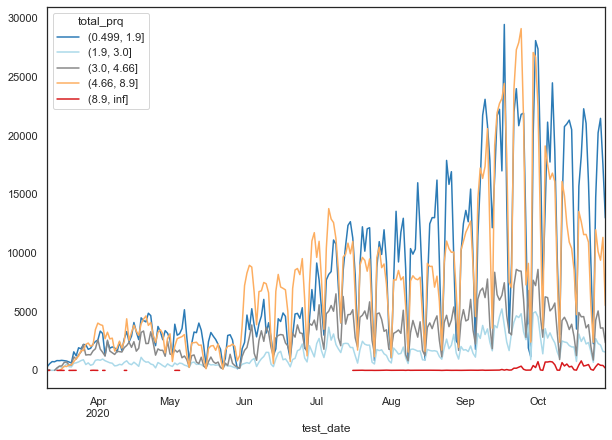

In [79]:
sns.set_palette(['#d7191c','#fdae61','#888888','#abd9e9','#2c7bb6'][::-1])
#sns.set_palette(['#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#b30000','#7f0000'])
sns.set_style('white')
prq = (polab.reset_index()
 .groupby(['test_date', 'total_prq']).total_tests.sum()
 .unstack()
)
prq.plot(figsize=(10,7))

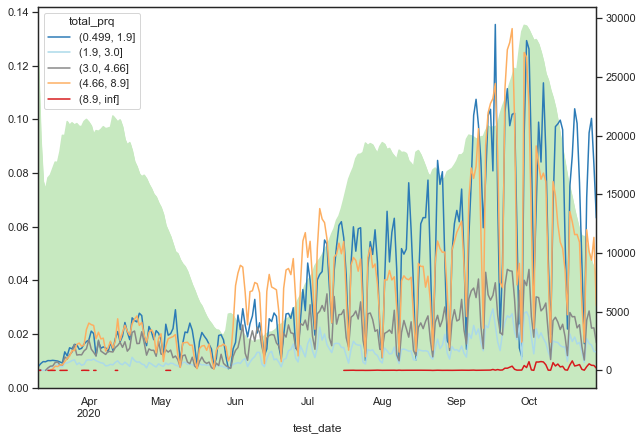

In [80]:
ax=(bdi.groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
    .assign(pr = lambda x: x.positive/(x.negative+x.positive+x.borderline+x.uncertain))
   ).pr.ewm(7).mean().plot(color='#c7e9c0', kind='area', figsize=(10,7))
ax2=ax.twinx()
prq.plot(ax=ax2)

## Decseased 

In [81]:
last_dec = pd.read_csv(get_latest_file_glob('datagov_archive/corona_deceased_ver*.csv.gz'), 
                       encoding='1255', low_memory=False, compression='gzip')
last_dec['qc'] = pd.qcut(last_dec.Length_of_hospitalization, 11, duplicates='drop')
last_dec.qc.value_counts().sort_index()/len(last_dec)

(-0.001, 2.0]    0.192611
(2.0, 4.0]       0.082192
(4.0, 6.0]       0.098796
(6.0, 8.0]       0.085513
(8.0, 10.0]      0.086343
(10.0, 13.0]     0.097551
(13.0, 17.0]     0.099211
(17.0, 21.0]     0.084267
(21.0, 29.0]     0.081777
(29.0, 209.0]    0.086343
Name: qc, dtype: float64

In [82]:
sns.set_palette('Set2')


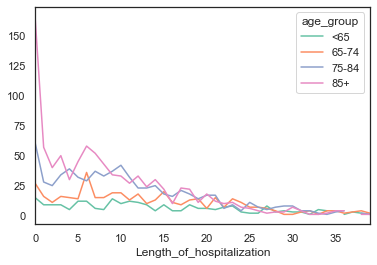

In [83]:
x = last_dec[last_dec['Length_of_hospitalization']<40].groupby(['Length_of_hospitalization', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.plot()

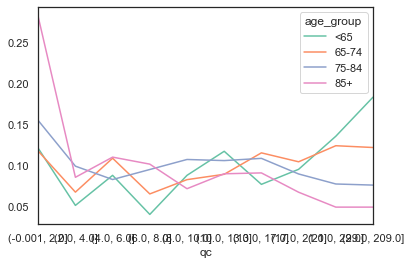

In [84]:
x = last_dec.groupby(['qc', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=0), axis=1).plot()

In [85]:
(last_dec.Length_of_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

0.0    0.111665
1.0    0.045662
2.0    0.035284
3.0    0.045247
4.0    0.036945
5.0    0.042756
6.0    0.056040
7.0    0.045662
8.0    0.039851
9.0    0.043171
Name: Length_of_hospitalization, dtype: float64

In [86]:
(last_dec.Time_between_positive_and_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

-203.0    0.000415
-141.0    0.000415
-63.0     0.000415
-52.0     0.000415
-44.0     0.000415
-36.0     0.000415
-31.0     0.000415
-26.0     0.000830
-25.0     0.000830
-23.0     0.000415
Name: Time_between_positive_and_hospitalization, dtype: float64

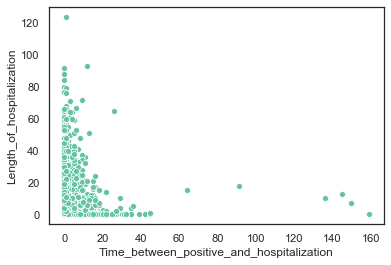

In [87]:
sns.scatterplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='Time_between_positive_and_hospitalization', y='Length_of_hospitalization')

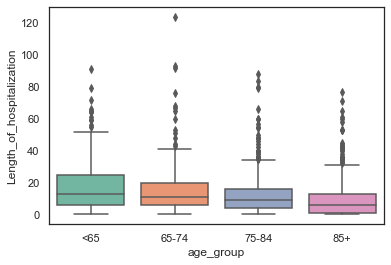

In [88]:
sns.boxplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='age_group', y='Length_of_hospitalization', order=['<65', '65-74', '75-84', '85+'])

In [89]:
decs = []
for file in sorted(glob.glob('datagov_archive/corona_deceased_ver*.csv.gz'), key=os.path.getctime) :
    for enc in ['1255', 'utf-8-sig']:
        try:
            dec = pd.read_csv(file, 
                  encoding=enc, low_memory=False)
        except:
            continue
    dec['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    dec.time = dec.time
    dec['file'] = file
    decs.append(dec)

decs = pd.concat(decs).sort_values('time')
decs.head()

gender age_group  Ventilated  Time_between_positive_and_hospitalization  \
0      זכר       <65         1.0                                        2.0   
203   נקבה     75-84         1.0                                        0.0   
202   נקבה       85+         0.0                                       10.0   
201   נקבה       85+         0.0                                        2.0   
200    זכר       85+         1.0                                        0.0   

     Length_of_hospitalization  Time_between_positive_and_death  \
0                         20.0                             22.0   
203                       12.0                             12.0   
202                        1.0                             11.0   
201                       17.0                             19.0   
200                        9.0                              9.0   

                   time                                            file  
0   2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz  
203 2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz  
202 2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz  
201 2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz  
200 2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz

In [90]:
decs.shape, (decs.drop_duplicates(subset=['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death']).shape)

((39250, 8), (1802, 8))

In [91]:
decs.columns

Index(['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death', 'time',
       'file'],
      dtype='object')

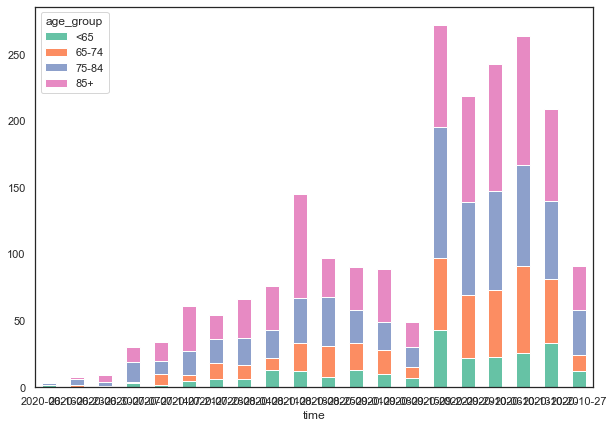

In [92]:
dec_dif = decs.groupby(['time', 'age_group']).size().unstack().diff()

dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

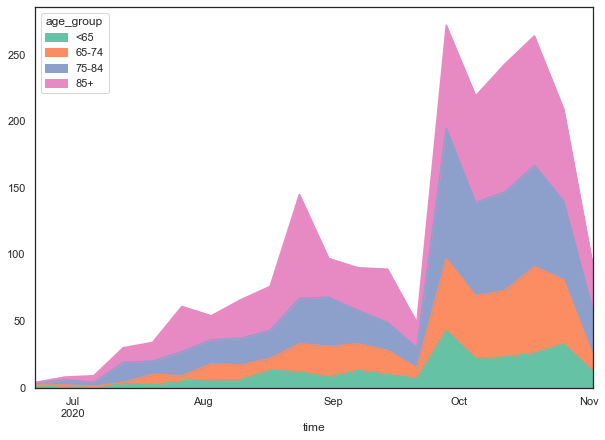

In [93]:
dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='area', figsize=(10,7), rot=0)

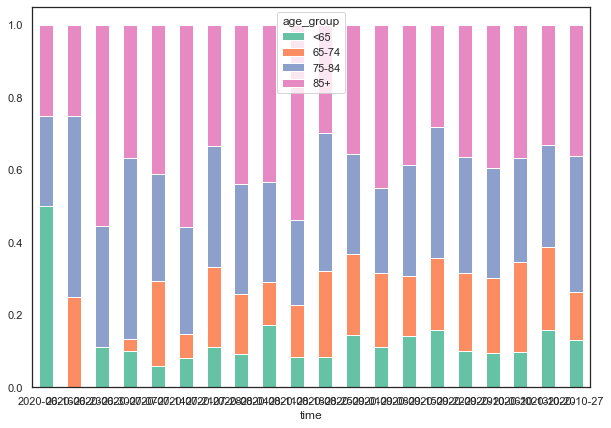

In [94]:
x = dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

In [95]:
dec_dif = decs.groupby(['time', 'Ventilated']).size().unstack().diff()

x = dec_dif.resample('7d', kind='period').sum()


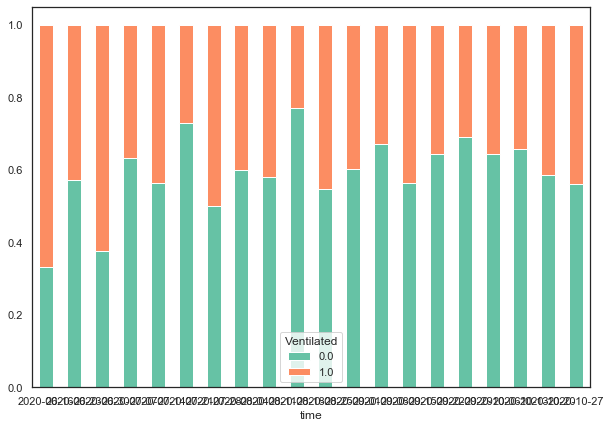

In [96]:
x.div(x.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

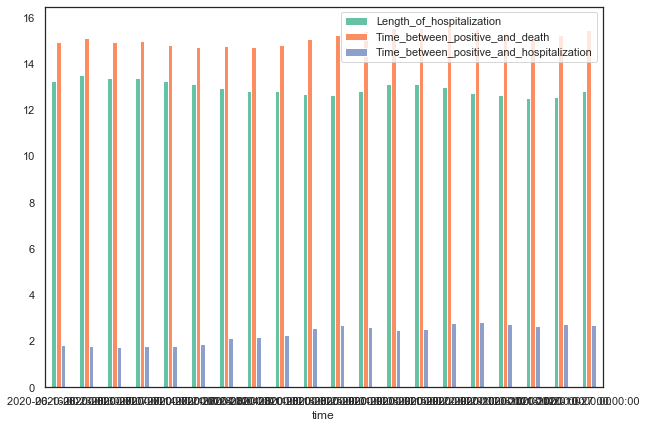

In [97]:
decs.resample('7d', on='time')[['Length_of_hospitalization', 'Time_between_positive_and_death', 'Time_between_positive_and_hospitalization']].mean().plot(kind='bar', figsize=(10,7), rot=0)


In [98]:
hos.head().T

0                    1  \
date                        2020-03-11 00:00:00  2020-03-12 00:00:00   
מאושפזים                                     79                  102   
אחוז נשים מאושפזות                         36.7                 40.2   
גיל ממוצע מאושפזים                           48                   50   
סטיית תקן גיל מאושפזים                     17.9                 18.1   
resp                                         15                   15   
אחוז נשים מונשמות                            20                   20   
גיל ממוצע מונשמים                            64                   64   
סטיית תקן גיל מונשמים                      15.4                 15.4   
חולים קל                                     72                   95   
אחוז נשים חולות קל                         37.5                 41.1   
גיל ממוצע חולים קל                           47                   49   
סטיית תקן גיל חולים קל                     17.3                 17.8   
medium                                       15                   15   
אחוז נשים חולות בינוני                      <15                  <15   
גיל ממוצע חולים בינוני                      <15                  <15   
סטיית תקן גיל חולים בינוני                  <15                  <15   
critical                                     15                   15   
אחוז נשים חולות קשה                        33.3                 33.3   
גיל ממוצע חולים קשה                          67                   67   
סטיית תקן גיל חולים קשה                    16.3                 16.3   
חולים קשה מצטבר                             <15                  <15   

                                              2                    3  \
date                        2020-03-13 00:00:00  2020-03-14 00:00:00   
מאושפזים                                    120                  158   
אחוז נשים מאושפזות                         39.2                 41.1   
גיל ממוצע מאושפזים                           50                   48   
סטיית תקן גיל מאושפזים                     18.2                 18.4   
resp                                         15                   15   
אחוז נשים מונשמות                            20                    0   
גיל ממוצע מונשמים                            64                   70   
סטיית תקן גיל מונשמים                      15.4                  7.4   
חולים קל                                    109                  148   
אחוז נשים חולות קל                         39.4                 41.9   
גיל ממוצע חולים קל                           48                   46   
סטיית תקן גיל חולים קל                     17.5                 17.5   
medium                                       15                   15   
אחוז נשים חולות בינוני                       40                   40   
גיל ממוצע חולים בינוני                       68                   68   
סטיית תקן גיל חולים בינוני                   17                   17   
critical                                     15                   15   
אחוז נשים חולות קשה                        33.3                   20   
גיל ממוצע חולים קשה                          67                   76   
סטיית תקן גיל חולים קשה                    16.3                 10.3   
חולים קשה מצטבר                             <15                  <15   

                                              4  
date                        2020-03-15 00:00:00  
מאושפזים                                    197  
אחוז נשים מאושפזות                         44.2  
גיל ממוצע מאושפזים                           47  
סטיית תקן גיל מאושפזים                     18.7  
resp                                         15  
אחוז נשים מונשמות                            20  
גיל ממוצע מונשמים                            74  
סטיית תקן גיל מונשמים                       7.6  
חולים קל                                    182  
אחוז נשים חולות קל                         44.5  
גיל ממוצע חולים קל                           45  
סטיית תקן גיל חולים קל                     17.6  
medium                          

In [99]:
rec.head()

days_between_pos_and_neg total_tests_count age_group gender  \
0                        19                 9     40-49    זכר   
1                        22                 9     30-39    זכר   
2                        26                 9     30-39    זכר   
3                        28                 9     30-39   נקבה   
4                        23                 9     20-29   נקבה   

          test_indication  
0                  Abroad  
1  Contact with confirmed  
2  Contact with confirmed  
3                  Abroad  
4  Contact with confirmed

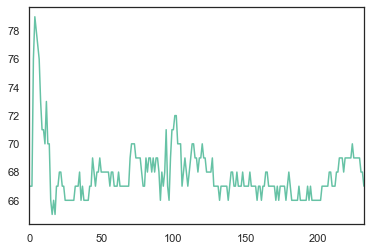

In [100]:
hos['גיל ממוצע חולים קשה'].plot()

## Recovered

In [101]:
pd.read_csv('datagov_archive/corona_recovered_ver_004.csv.gz', encoding='1255')

days_between_pos_and_neg total_tests_count age_group gender  \
0                          8.0                 9     40-49   נקבה   
1                         19.0                 9     30-39    זכר   
2                         33.0                 9       60+    זכר   
3                         24.0                 9     30-39    זכר   
4                         20.0                 9     40-49    זכר   
...                        ...               ...       ...    ...   
6408                       NaN               NaN       60+    זכר   
6409                       NaN               NaN       60+   נקבה   
6410                       NaN               NaN       60+   נקבה   
6411                       NaN               NaN       60+    זכר   
6412                       NaN               NaN       60+    זכר   

             test_indication  
0     Contact with confirmed  
1     Contact with confirmed  
2                     Abroad  
3     Contact with confirmed  
4                     Abroad  
...                      ...  
6408                   Other  
6409  Contact with confirmed  
6410  Contact with confirmed  
6411                  Abroad  
6412                  Abroad  

[6413 rows x 5 columns]

In [102]:
recs = []
for file in sorted(glob.glob('datagov_archive/corona_recovered*.csv.gz'), key=os.path.getctime) :
    try:
        r = pd.read_csv(file, 
                  encoding='1255', low_memory=False)
    except:
        r = pd.read_csv(file, 
                  encoding='utf-8', low_memory=False)
    print(file, pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False))
    r['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    r['file'] = file
    recs.append(r)

recs = pd.concat(recs)
recs['ver'] = recs.file.str.extract('ver_0+([1-9][0-9]*)').astype(int)
recs = recs.sort_values('ver')
recs.head()

datagov_archive\corona_recovered_ver_0010.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_0012.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_004.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_005.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_006.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_007.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_008.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_0016.csv.gz 2020-06-10 10:31:01
datagov_archive\corona_recovered_ver_0017.csv.gz 2020-06-11 13:45:44
datagov_archive\corona_recovered_ver_0018.csv.gz 2020-06-16 12:09:51
datagov_archive\corona_recovered_ver_0020.csv.gz 2020-06-19 12:31:14
datagov_archive\corona_recovered_ver_0021.csv.gz 2020-06-22 19:27:14
datagov_archive\corona_recovered_ver_0023.csv.gz 2020-06-28 07:56:06
datagov_archive\corona_recovered_ver_0024.csv.gz 2020-06-29 09:30:26
datagov_archive\corona_recovered_ver_00

days_between_pos_and_neg total_tests_count age_group gender  \
4923                      12.0                 3     30-39   נקבה   
4281                      15.0                 3     40-49   נקבה   
4280                       4.0                 3     20-29   נקבה   
4279                      13.0                 3     50-59    זכר   
4278                       7.0                 3     30-39   נקבה   

     test_indication                time  \
4923           Other 2020-05-30 14:05:58   
4281           Other 2020-05-30 14:05:58   
4280           Other 2020-05-30 14:05:58   
4279           Other 2020-05-30 14:05:58   
4278          Abroad 2020-05-30 14:05:58   

                                                 file  ver  
4923  datagov_archive\corona_recovered_ver_004.csv.gz    4  
4281  datagov_archive\corona_recovered_ver_004.csv.gz    4  
4280  datagov_archive\corona_recovered_ver_004.csv.gz    4  
4279  datagov_archive\corona_recovered_ver_004.csv.gz    4  
4278  datagov_archive\corona_recovered_ver_004.csv.gz    4

In [103]:
recs.ver.value_counts()

35    23651
34    21193
33    19878
32    18529
31    17913
26    16922
25    16427
24    16158
23    15883
21    15650
20    15485
18    15383
17    15254
16    15139
12    13863
10    12841
8     11251
7     10828
6      9419
5      8492
4      6413
Name: ver, dtype: int64

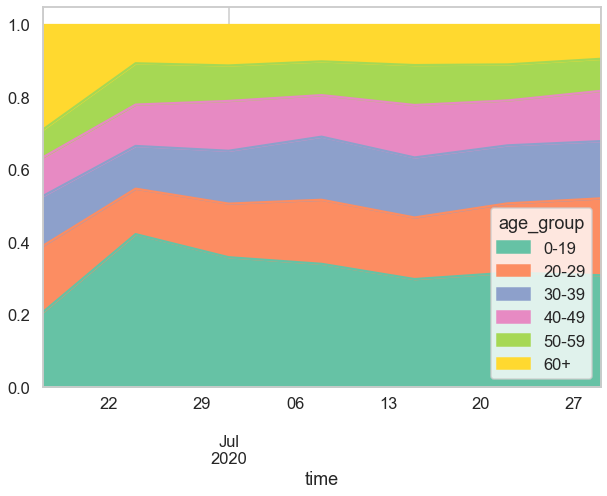

In [104]:
sns.set_style('whitegrid')
sns.set_context('talk')

rec_dif = recs[recs.ver>=17].groupby(['time', 'age_group']).size().unstack().diff()
rec_dif
x=rec_dif.resample('7d', kind='period').sum()

x.div(x.sum(axis=1),axis=0).plot(kind='area', figsize=(10,7), rot=0)

## Age & Gender

In [105]:
import gzip

def get_sep(path, encoding='utf-8'):
    if '.gz' in path:
        my_open=gzip.open
    else:
        my_open=open
    with my_open(path, 'rt', encoding=encoding) as f:
        first_line = f.readline()
    if '\t' in first_line:
        sep='\t'
    else:
        sep=','
    return sep

def get_latest_df(prefix, data_folder='datagov_archive', suffix='*.csv.gz'):
    pat = os.path.join(data_folder, prefix+suffix)
    latest = get_latest_file_glob(pat)
    
    try:
        sep = get_sep(latest, '1255')
        df = pd.read_csv(latest, 
                  encoding='1255', low_memory=False, sep=sep)
    except:
        sep = get_sep(latest, 'utf-8-sig')
        df = pd.read_csv(latest, 
                  encoding='utf-8-sig', low_memory=False, sep=sep)
    return df
                
ag = get_latest_df('corona_age_and_gender')
ag.head()
    

first_week_day last_week_day age_group   gender weekly_tests_num  \
0     2020-03-15    2020-03-21      0-19  לא ידוע             29.0   
1     2020-03-15    2020-03-21      0-19      זכר           1088.0   
2     2020-03-15    2020-03-21      0-19     נקבה            899.0   
3     2020-03-15    2020-03-21     20-24  לא ידוע              <15   
4     2020-03-15    2020-03-21     20-24      זכר            695.0   

  weekly_newly_tested weekly_cases weekly_deceased  
0                29.0          0.0             0.0  
1              1037.0         37.0             0.0  
2               863.0         39.0             0.0  
3                 <15          0.0             0.0  
4               650.0        105.0             0.0

In [106]:
ag.weekly_deceased.value_counts()

0.0     1090
<15      303
15.0       5
20.0       4
35.0       3
21.0       3
27.0       3
16.0       2
18.0       2
33.0       2
31.0       2
26.0       2
28.0       2
78.0       2
22.0       2
19.0       1
23.0       1
50.0       1
59.0       1
56.0       1
69.0       1
52.0       1
61.0       1
46.0       1
24.0       1
66.0       1
25.0       1
17.0       1
Name: weekly_deceased, dtype: int64

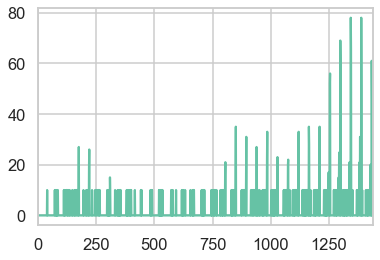

In [107]:
ag.weekly_deceased.replace('<15','10').astype(float).astype(int).plot()

## Dashboard Data

In [108]:
dash_folder = 'dashboard_data'
city_file_name = 'contagionDataPerCityPublic.csv'

In [109]:
city_df = pd.DataFrame()
for folder in os.scandir(dash_folder):
    if os.path.isdir(folder):
        for tfolder in os.scandir(folder):
            if os.path.isdir(tfolder):
                city_df = city_df.append(pd.read_csv(os.path.join(tfolder, city_file_name)), sort=False)
                
city_df['date'] = pd.to_datetime(city_df.date)
city_df.head()

city sickCount actualSick verifiedLast7Days  testLast7Days  \
0        ירושלים     16214       3748              1266          13868   
1        בני ברק      9144       1252               482           3043   
2  מודיעין עילית      3122       1085               475           2004   
3            רהט       780        240               118            792   
4       כפר קאסם       455        185               109            501   

   patientDiffPopulationForTenThousands                             status  \
0                                    40  נדרשים הסברה, בדיקות ואכיפת בידוד   
1                                    62  נדרשים הסברה, בדיקות ואכיפת בידוד   
2                                   141  נדרשים הסברה, בדיקות ואכיפת בידוד   
3                                    36  נדרשים הסברה, בדיקות ואכיפת בידוד   
4                                    77  נדרשים הסברה, בדיקות ואכיפת בידוד   

                 lastUpdate                             date  
0  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
1  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
2  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
3  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
4  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00

In [110]:
city_df.dtypes

city                                                 object
sickCount                                            object
actualSick                                           object
verifiedLast7Days                                    object
testLast7Days                                         int64
patientDiffPopulationForTenThousands                  int64
status                                               object
lastUpdate                                           object
date                                    datetime64[ns, UTC]
dtype: object

In [111]:
city_tests = (city_df
              .groupby([pd.Grouper(key='date', freq='1d'), 'city'])['testLast7Days', 'verifiedLast7Days'].max()
              .assign(positive_rate = lambda x: x.verifiedLast7Days.str.strip().replace('<15', '8').replace('1-5', '3').replace('6-10', '8').replace('11-14', '13').astype(int) / x.testLast7Days)
              .reset_index())
city_tests.head()

date                city  testLast7Days  \
0 2020-08-19 00:00:00+00:00  אבו ג'ווייעד (שבט)             12   
1 2020-08-19 00:00:00+00:00             אבו גוש            256   
2 2020-08-19 00:00:00+00:00            אבו סנאן            399   
3 2020-08-19 00:00:00+00:00   אבו קורינאת (שבט)             13   
4 2020-08-19 00:00:00+00:00   אבו רובייעה (שבט)             20   

  verifiedLast7Days  positive_rate  
0                 0       0.000000  
1                24       0.093750  
2                18       0.045113  
3                 0       0.000000  
4                 0       0.000000

In [112]:
#top_cities = city_tests.groupby('city').testLast7Days.mean().sort_values(ascending=False)[:20].index
from datetime import date, timedelta
yesterday = city_tests.date.max() - timedelta(days=1)
top_cities = city_tests[city_tests.date==yesterday].sort_values(by='testLast7Days', ascending=False).head(20).city

In [113]:
alt.Chart(city_tests[city_tests.city.isin(top_cities)]).mark_trail().encode(
    x='date',
    y='testLast7Days',
    size=alt.Size('positive_rate:Q', bin={'steps':[0.02,0.05,0.1]}),
    color='city',
    tooltip=['date', 'city', 'testLast7Days', 'positive_rate']
).properties(width=600, height=450).interactive()

alt.Chart(...)

In [114]:
alt.Chart(city_tests[city_tests.city.isin(top_cities)]).transform_joinaggregate(
     groupby = ['date'], TotalTests='sum(testLast7Days)',
).transform_calculate(
    PercentTests="datum.testLast7Days / datum.TotalTests"
).mark_area().encode(
    x='date',
    y='PercentTests:Q',
    color='city',
    #size='mean(positive_rate)',
    tooltip=['date', 'city', 'PercentTests:Q']
).properties(width=600, height=450).interactive()

alt.Chart(...)

In [115]:
alt.Chart(city_tests[city_tests.city.isin(top_cities)]).mark_trail().encode(
    x='date',
    y='positive_rate',
    size=alt.Size('testLast7Days', bin={'steps':[1000,2000,5000,10000]}),
    color='city',
    tooltip=['date', 'city', 'testLast7Days', 'positive_rate']
).properties(width=600, height=450).interactive()

alt.Chart(...)

In [116]:
ct_change = (city_tests[city_tests.date.isin(['2020-08-31',yesterday.strftime('%Y-%m-%d') ])]
 .assign(date = lambda x: x.date.dt.strftime('%Y-%m-%d'))            
 .pivot(index='city', columns='date')[['testLast7Days', 'positive_rate']]
 .assign(test_ratio=lambda x: (x.iloc[:, 1]/x.iloc[:,0]).round(2))
 .assign(pr_ratio=lambda x: (x.iloc[:, 3]/x.iloc[:,2]).round(2))
 .assign(positive_rate = lambda x: x.positive_rate.round(2))
 .sort_values(by='test_ratio', ascending=False)
 
 )
ct_change[ct_change[('testLast7Days', yesterday.strftime('%Y-%m-%d'))]>=300].head(30)#.loc[list(top_cities), :]


testLast7Days            positive_rate            test_ratio  \
date                2020-08-31 2020-11-01    2020-08-31 2020-11-01              
city                                                                            
מג'דל שמס                  103        796          0.08       0.11       7.73   
בית אל                      95        494          0.03       0.01       5.20   
בועיינה-נוג'ידאת           151        584          0.14       0.08       3.87   
אלפי מנשה                   95        337          0.00       0.01       3.55   
מעלות-תרשיחא               367       1194          0.04       0.02       3.25   
כפר חב"ד                   102        330          0.13       0.06       3.24   
אילת                       520       1482          0.05       0.01       2.85   
ירוחם                      116        319          0.03       0.01       2.75   
בית שאן                    206        555          0.06       0.01       2.69   
גבעת שמואל                 302        785          0.07       0.00       2.60   
קרית טבעון                 239        611          0.01       0.00       2.56   
קרית עקרון                 149        361          0.05       0.01       2.42   
יבנה                       521       1255          0.08       0.01       2.41   
חורפיש                     131        300          0.02       0.06       2.29   
אריאל                      206        459          0.01       0.01       2.23   
גן יבנה                    272        599          0.03       0.01       2.20   
אפרת                       174        379          0.07       0.01       2.18   
ראש העין                   981       2104          0.06       0.02       2.14   
גבעתיים                    714       1504          0.04       0.00       2.11   
לוד                       1027       2147          0.07       0.02       2.09   
הוד השרון                  844       1751          0.05       0.00       2.07   
ערד                        346        709          0.02       0.02       2.05   
באר יעקב                   311        634          0.08       0.00       2.04   
מעלה אדומים                738       1484          0.04       0.02       2.01   
גני תקווה                  255        511          0.05       0.02       2.00   
גדרה                       484        962          0.05       0.01       1.99   
רמת גן                    2274       4384          0.04       0.01       1.93   
נס ציונה                   488        922          0.05       0.01       1.89   
רחובות                    1691       3199          0.05       0.01       1.89   
ראשון לציון               3271       5979          0.05       0.01       1.83   

                 pr_ratio  
date                       
city                       
מג'דל שמס            1.41  
בית אל               0.19  
בועיינה-נוג'ידאת     0.57  
אלפי מנשה             inf  
מעלות-תרשיחא         0.50  
כפר חב"ד             0.48  
אילת                 0.10  
ירוחם                0.36  
בית שאן              0.23  
גבעת שמואל           0.05  
קרית טבעון           0.39  
קרית עקרון           0.15  
יבנה                 0.16  
חורפיש               2.47  
אריאל                0.45  
גן יבנה              0.17  
אפרת                 0.11  
ראש העין             0.30  
גבעתיים              0.05  
לוד                  0.25  
הוד השרון            0.08  
ערד                  0.79  
באר יעקב             0.06  
מעלה אדומים          0.48  
גני תקווה            0.31  
גדרה                 0.17  
רמת גן               0.18  
נס ציונה             0.19  
רחובות               0.15  
ראשון לציון          0.22

C:\Users\dbare\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


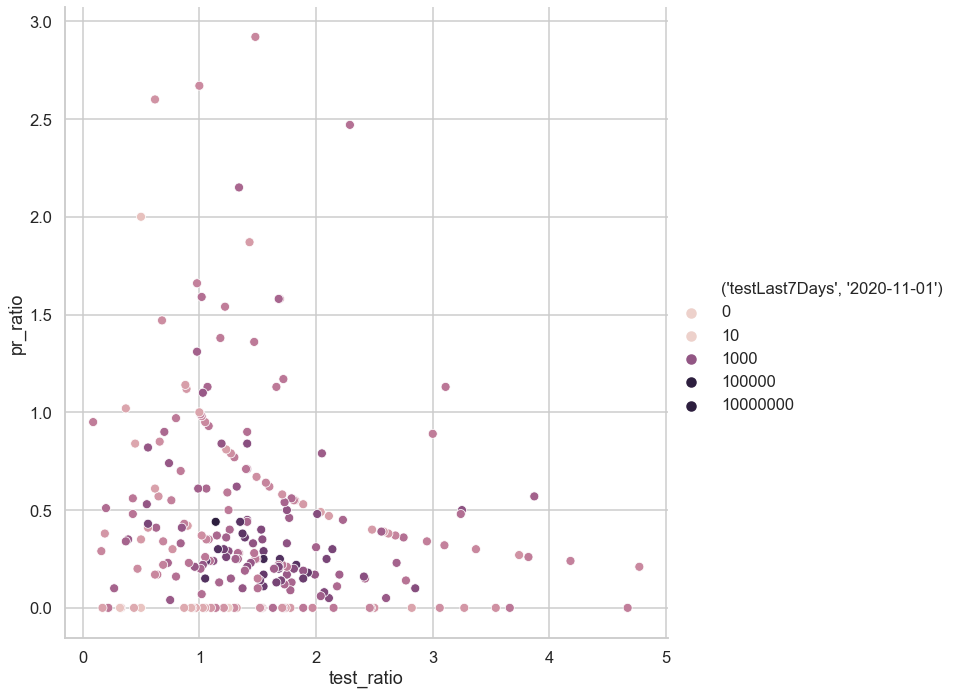

In [117]:
from matplotlib.colors import LogNorm

sns.relplot(data=ct_change[(ct_change.test_ratio<5) & (ct_change.pr_ratio<4)], x='test_ratio', y='pr_ratio', 
            hue=('testLast7Days', yesterday.strftime('%Y-%m-%d')), hue_norm=LogNorm(),
            height=10)

In [118]:
tr_file_name = 'testResultsPerDate.csv'

In [119]:
tr_df = pd.DataFrame()
for folder in os.scandir(dash_folder):
    if os.path.isdir(folder):
        for tfolder in os.scandir(folder):
            if os.path.isdir(tfolder):
                tr_df = tr_df.append(pd.read_csv(os.path.join(tfolder, tr_file_name)), sort=False)
                
tr_df['date'] = pd.to_datetime(tr_df.date)
tr_df.tail()

date  amount  amountVirusDiagnosis  positiveAmount  \
274 2020-10-29 00:00:00+00:00   37455                 36216             644   
275 2020-10-30 00:00:00+00:00   32627                 31697             678   
276 2020-10-31 00:00:00+00:00    7974                  7662             220   
277 2020-11-01 00:00:00+00:00   21894                 21115             649   
278 2020-11-02 00:00:00+00:00    5895                  5752              27   

                   lastUpdate  
274  2020-11-02T03:27:15.743Z  
275  2020-11-02T03:27:15.743Z  
276  2020-11-02T03:27:15.743Z  
277  2020-11-02T03:27:15.743Z  
278  2020-11-02T03:27:15.743Z

In [120]:
tr_df.dtypes

date                    datetime64[ns, UTC]
amount                                int64
amountVirusDiagnosis                  int64
positiveAmount                        int64
lastUpdate                           object
dtype: object

In [121]:
tr = (tr_df.sort_values('lastUpdate', ascending=False)
              .groupby(['date']).head(1)
              .sort_values('date')
     .assign(positive_rate = lambda x: x.positiveAmount/x.amountVirusDiagnosis))
tr.tail()

date  amount  amountVirusDiagnosis  positiveAmount  \
274 2020-10-29 00:00:00+00:00   37455                 36216             644   
275 2020-10-30 00:00:00+00:00   32627                 31697             678   
276 2020-10-31 00:00:00+00:00    7974                  7662             220   
277 2020-11-01 00:00:00+00:00   21894                 21115             649   
278 2020-11-02 00:00:00+00:00    5895                  5752              27   

                   lastUpdate  positive_rate  
274  2020-11-02T03:27:15.743Z       0.017782  
275  2020-11-02T03:27:15.743Z       0.021390  
276  2020-11-02T03:27:15.743Z       0.028713  
277  2020-11-02T03:27:15.743Z       0.030736  
278  2020-11-02T03:27:15.743Z       0.004694